In [18]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
from tvtk.api import  tvtk
import mayavi.sources.vtk_data_source 
import mayavi.mlab
import matplotlib.cm
import matplotlib.colors
import osgeo.osr
import datetime
import pandas
import scipy.interpolate
import requests
import io
import collections
import python_subgrid.particles
import logging
logging.basicConfig()
logging.root.setLevel(logging.DEBUG)
import pandas
import datetime
import numpy as np
import netCDF4
import osgeo.osr
import tables
import shapely.geometry
import shapely.prepared
import matplotlib.pyplot as plt
import dateutil.rrule


%matplotlib inline

%matplotlib inline

In [2]:
ds = netCDF4.Dataset('/Users/baart_f/models/sfo/sfo-3di/subgrid_map_15min.nc')


In [15]:
t_min, t_max = datetime.datetime(1962, 6, 11, 20, 0), datetime.datetime(1962, 6, 12, 4, 0)

# lookup the indices in the 2d result file
ds = netCDF4.Dataset('/Users/baart_f/models/sfo/sfo-3di/subgrid_map_15min.nc')
times = netCDF4.num2date(ds.variables['time'][:], ds.variables['time'].units)

# convert to indices
idx,  = np.where((times >= t_min) & (times < t_max))


array([datetime.datetime(1962, 6, 11, 20, 0),
       datetime.datetime(1962, 6, 11, 20, 15),
       datetime.datetime(1962, 6, 11, 20, 30),
       datetime.datetime(1962, 6, 11, 20, 45),
       datetime.datetime(1962, 6, 11, 21, 0),
       datetime.datetime(1962, 6, 11, 21, 15),
       datetime.datetime(1962, 6, 11, 21, 30),
       datetime.datetime(1962, 6, 11, 21, 45),
       datetime.datetime(1962, 6, 11, 22, 0),
       datetime.datetime(1962, 6, 11, 22, 15),
       datetime.datetime(1962, 6, 11, 22, 30),
       datetime.datetime(1962, 6, 11, 22, 45),
       datetime.datetime(1962, 6, 11, 23, 0),
       datetime.datetime(1962, 6, 11, 23, 15),
       datetime.datetime(1962, 6, 11, 23, 30),
       datetime.datetime(1962, 6, 11, 23, 45),
       datetime.datetime(1962, 6, 12, 0, 0),
       datetime.datetime(1962, 6, 12, 0, 15),
       datetime.datetime(1962, 6, 12, 0, 30),
       datetime.datetime(1962, 6, 12, 0, 45),
       datetime.datetime(1962, 6, 12, 1, 0),
       datetime.datetime

In [16]:
xc = ds.variables['FlowElemContour_x'][:]
yc = ds.variables['FlowElemContour_y'][:]
xcc = ds.variables['FlowElem_xcc'][:]
ycc = ds.variables['FlowElem_ycc'][:]

# variables at last timestep
ucx = ds.variables['ucx']
ucy = ds.variables['ucy']
s1 = ds.variables['s1']


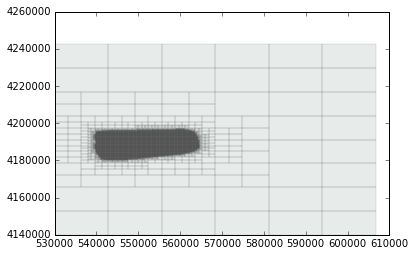

In [23]:
verts = [np.c_[x,y] for x,y in zip(xc, yc)]
fig, ax = plt.subplots()
polys = matplotlib.collections.PolyCollection(verts, facecolor=(0.1,0.3,0.2,0.1), linewidth=0.1, transOffset=ax.transData)
ax.add_collection(polys)
ax.autoscale()

In [24]:
ll = (542324.8953110904, 4178557.256203641)
ur = (565429.5404843381, 4194114.96778207)

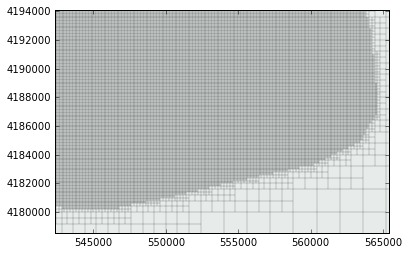

In [28]:
ax.set_xlim(ll[0], ur[0])
ax.set_ylim(ll[1], ur[1])
fig

In [29]:
# generate the spatial reference systems and the transformations
utm_srs = osgeo.osr.SpatialReference()
utm_srs.ImportFromEPSGA(26910)
osm_srs = osgeo.osr.SpatialReference()
osm_srs.ImportFromEPSGA(3857)
wgs_srs = osgeo.osr.SpatialReference()
wgs_srs.ImportFromEPSGA(4326)
utm2wgs = osgeo.osr.CoordinateTransformation(utm_srs, wgs_srs)
utm2osm = osgeo.osr.CoordinateTransformation(utm_srs, osm_srs)
wgs2utm = osgeo.osr.CoordinateTransformation(wgs_srs, utm_srs)
wgs2osm = osgeo.osr.CoordinateTransformation(wgs_srs, osm_srs)

In [30]:
# define the location of the Alcatraz escape location
alcatraz = {}
alcatraz['lon'] = -122.4239052
alcatraz['lat'] = 37.8279125
alcatraz['x_osm'], alcatraz['y_osm'], _ = wgs2osm.TransformPoint(alcatraz['lon'], alcatraz['lat'])
alcatraz['x_utm'], alcatraz['y_utm'], _ = wgs2utm.TransformPoint(alcatraz['lon'], alcatraz['lat'])


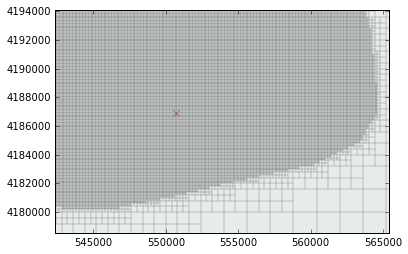

In [33]:
ax.plot(alcatraz['x_utm'], alcatraz['y_utm'], 'rx')

fig

(4178557.256203641, 4194114.96778207)

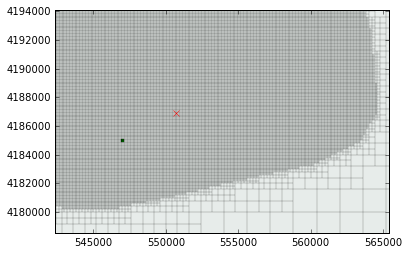

In [81]:
xidx = np.isclose(xcc, 547000, atol=100)
yidx = np.isclose(ycc, 4185000, atol=100)
fig, ax = plt.subplots()
polys = matplotlib.collections.PolyCollection(verts, facecolor=(0.1,0.3,0.2,0.1), linewidth=0.1, transOffset=ax.transData)
ax.add_collection(polys)
polys = matplotlib.collections.PolyCollection(np.array(verts)[xidx & yidx], facecolor='green', linewidth=0.3, transOffset=ax.transData)
ax.add_collection(polys)
ax.plot(alcatraz['x_utm'], alcatraz['y_utm'], 'rx')
ax.set_xlim(ll[0], ur[0])
ax.set_ylim(ll[1], ur[1])



In [82]:
(xidx & yidx).sum()

4

In [88]:
pt_idx, = np.where(xidx & yidx)

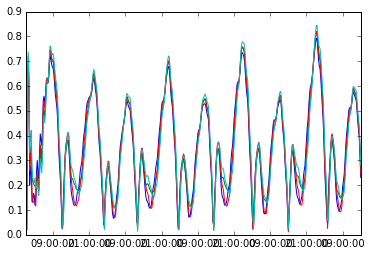

In [95]:
plt.plot(
    times,
    np.sqrt(ds.variables['ucx'][:,pt_idx ] ** 2 + ds.variables['ucy'][:,pt_idx ]**2).squeeze()
    )

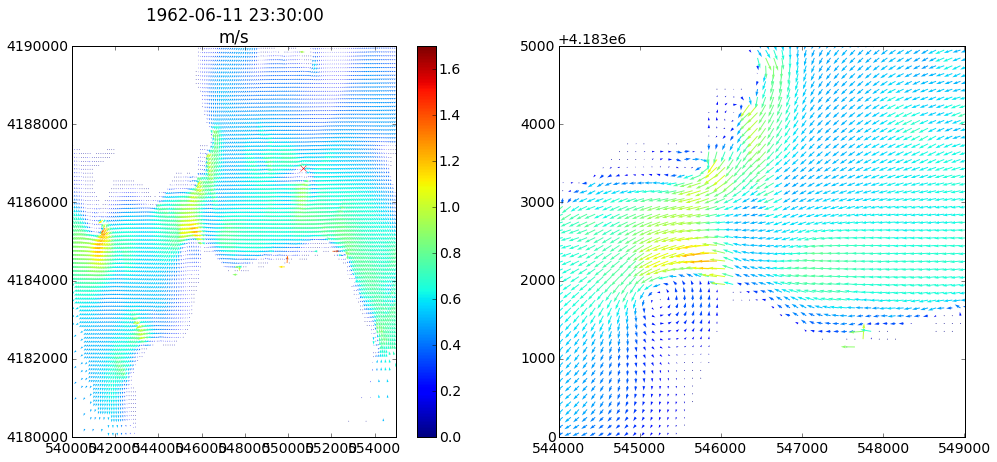

In [176]:
import cmocean.cm
ll = (540000, 4180000)
ur = (555000, 4190000)
def plot(i=286):
    
    u = ds.variables['ucx'][i, :]
    v = ds.variables['ucy'][i, :]
    vol = ds.variables['vol'][i,:]
    u = np.ma.masked_where(vol < 0.1, u)
    v = np.ma.masked_where(vol < 0.1, v)
    fig, axes = plt.subplots(1,2,figsize=(16,7))
    ax = axes[0]
    q = ax.quiver(xcc, ycc, u, v, np.sqrt(u**2 + v**2), cmap='jet', clim=(0,1.7), units='xy', scale=5e-3)
    ax.set_xlim(ll[0], ur[0])
    ax.set_ylim(ll[1], ur[1])
    ax.plot(alcatraz['x_utm'], alcatraz['y_utm'], 'rx')
    plt.colorbar(q, ax=ax)
    ax.set_title(str(times[i]) + '\n' + ds.variables['ucx'].units)

    ax = axes[1]
    q = ax.quiver(xcc, ycc, u, v, np.sqrt(u**2 + v**2), cmap='jet', clim=(0,1.7), units='xy', scale=5e-3)
    ax.set_xlim(ll[0]+4000, ur[0]-6000)
    ax.set_ylim(ll[1]+3000, ur[1]-2000)
    
from IPython.html.widgets import interactive
interactive(plot, i=(270,310,1))

(445, 36399)